In [1]:
import pandas as pd

#type
train_df = pd.read_csv('../data/train_df.csv')
test_df = pd.read_csv('../data/test_df.csv')

In [2]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, classification_report

features = ['name_lower', 'type_lower', 'category_l2', 'category_l4', 'type_in_name']
cat_features = [0, 1, 2, 3]

X_train = train_df[features]
y_train = train_df['target']
X_test = test_df[features]
y_test = test_df['target']

train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.2,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=50,
    random_state=42
)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=30)

0:	test: 0.9593191	best: 0.9593191 (0)	total: 689ms	remaining: 3m 26s
50:	test: 0.9865958	best: 0.9865958 (50)	total: 9.89s	remaining: 48.3s
100:	test: 0.9869715	best: 0.9869715 (100)	total: 17.2s	remaining: 33.9s
150:	test: 0.9871955	best: 0.9871955 (150)	total: 24.3s	remaining: 24s
200:	test: 0.9872592	best: 0.9872611 (196)	total: 31s	remaining: 15.3s
250:	test: 0.9873145	best: 0.9873145 (250)	total: 38.8s	remaining: 7.57s
299:	test: 0.9873675	best: 0.9873683 (298)	total: 45.9s	remaining: 0us

bestTest = 0.9873683057
bestIteration = 298

Shrink model to first 299 iterations.


In [4]:
y_pred_proba = model.predict_proba(test_pool)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC на тесте: {roc_auc:.4f}')
print(classification_report(y_test, model.predict(X_test)))

ROC-AUC на тесте: 0.9874
              precision    recall  f1-score   support

           0       0.91      0.94      0.93     38476
           1       0.96      0.95      0.96     66906

    accuracy                           0.94    105382
   macro avg       0.94      0.94      0.94    105382
weighted avg       0.95      0.94      0.94    105382



In [5]:
unique_types = train_df['type_lower'].unique()

def get_top_10_types(sample_row):
    candidate_rows = []
    for t in unique_types:
        row = sample_row.copy()
        row['type_lower'] = t
        row['type_in_name'] = int(t in row['name_lower'])
        candidate_rows.append(row)
    df_candidates = pd.DataFrame(candidate_rows)

    preds = model.predict_proba(df_candidates[features])[:, 1]
    top_10_idx = preds.argsort()[::-1][:10]
    top_10_types = df_candidates.iloc[top_10_idx][['type_lower']].copy()
    top_10_types['probability'] = preds[top_10_idx]
    return top_10_types.reset_index(drop=True)

# Пример ранжирования
sample = X_test.iloc[2457].copy()
top_10 = get_top_10_types(sample)
print(X_test.iloc[2457])
print(top_10)

name_lower                      куртка
type_lower      масло для смазки ножей
category_l2                     Одежда
category_l4                     Куртка
type_in_name                     False
Name: 2457, dtype: object
               type_lower  probability
0                  куртка     0.998737
1                 пуховик     0.979840
2          кожаная куртка     0.965312
3        куртка джинсовая     0.939665
4          куртка кожаная     0.920690
5       пальто утепленное     0.900706
6          пальто пуховое     0.850786
7  дубленка искусственная     0.821118
8                  пальто     0.697279
9        джинсовая куртка     0.535280


In [73]:
feature_importances = model.get_feature_importance(train_pool)
for name, score in zip(features, feature_importances):
    print(f"{name}: {score:.3f}")

name_lower: 18.205
type_lower: 28.642
category_l2: 10.537
category_l4: 17.319
type_in_name: 25.298


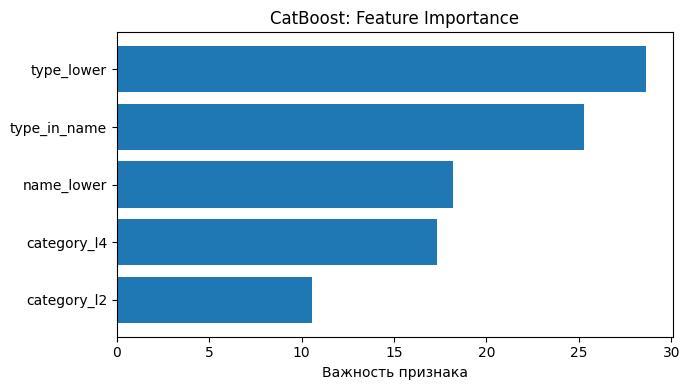

In [6]:
import matplotlib.pyplot as plt

feature_importances = model.get_feature_importance(train_pool)
feat_imp_df = pd.DataFrame({'feature': features, 'importance': feature_importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=True)

plt.figure(figsize=(7, 4))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'])
plt.xlabel('Важность признака')
plt.title('CatBoost: Feature Importance')
plt.tight_layout()
plt.show()

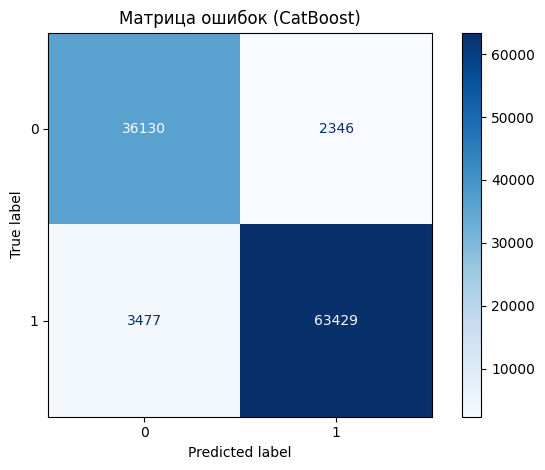

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(test_pool)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Матрица ошибок (CatBoost)')
plt.tight_layout()
plt.show()